This notebook evaluates the predictions for GRF curves, contact classification, and GRF distribution.

#  Input parameters here

In [19]:
# # PARAMETERS # #
BASE_DIR = '/content/drive/My Drive/CS230_FinalReport/' # your base directory
MASK_VALUE = 999.
MAX_TIMESTEPS = 112
EXP_TYPE = 'with_physicsinputs'
USE_TRANSFORMED = False
MODEL_NAME = '_lstm_interoutputs_fixclass' # ending filename for model
# # # # # # # # # #

# Load libraries and data

In [20]:
# Mount Drive to access data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

In [22]:
# Load in predictions and true labels
if USE_TRANSFORMED:
  pass
  #Y_true = np.load(file=os.path.join(BASE_DIR, 'models', EXP_TYPE + MODEL_NAME, 'Y_true_cont_transformed.npy'), allow_pickle = True)
else:
  #Y_true = np.load(file=os.path.join(BASE_DIR, 'data', 'processed', 'normalized', 'with_physicsinputs', 'Y_test_norm_100Hz_RawDist_InterOutputs.npy'), allow_pickle = True) # same for with and without
  Y_true = np.load(file=os.path.join(BASE_DIR, 'data', 'processed', 'not_normalized', 'with_physicsinputs', 'Y_test_100Hz_RawDist.npy'), allow_pickle = True) # same for with and without

# # For normalized data
#Y_true_total_grf = Y_true[:,:,0:3]
#Y_true_grf_r = Y_true[:,:,8:11]
#Y_true_grf_l = Y_true[:,:,11:]

#Y_true_class_r = np.expand_dims(Y_true[:,:,3], axis=-1)
#Y_true_class_l = np.expand_dims(Y_true[:,:,4], axis=-1)
#Y_true_dist_r = Y_true[:,:,5:8]

# # For not normalized data
Y_true_total_grf = np.expand_dims(Y_true[:,:,16], axis=-1) * Y_true[:,:,17:20]
Y_true_total_grf[Y_true_total_grf == MASK_VALUE**2] = MASK_VALUE # reset mask value

Y_true_class_r = np.expand_dims(Y_true[:,:,20], axis=-1)
Y_true_class_l = np.expand_dims(Y_true[:,:,21], axis=-1)

Y_true_dist_r = Y_true[:,:,22:25]

Y_true_grf_r = np.expand_dims(Y_true[:,:,0], axis=-1) * Y_true[:,:,1:4]
Y_true_grf_r[Y_true_grf_r == MASK_VALUE**2] = MASK_VALUE # reset mask value
Y_true_grf_l = np.expand_dims(Y_true[:,:,4], axis=-1) * Y_true[:,:,5:8]
Y_true_grf_l[Y_true_grf_l == MASK_VALUE**2] = MASK_VALUE # reset mask value

if USE_TRANSFORMED:
  pass
  #Y_pred_cont = np.load(file=os.path.join(BASE_DIR, 'models', EXP_TYPE + '_lstm_interoutputs', 'Y_pred_cont_transformed.npy'), allow_pickle = True)
else:
  Y_pred_total_grf = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + MODEL_NAME, 'testset_predictions_total_grf.npy'), allow_pickle = True)
  Y_pred_grf_r = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + MODEL_NAME, 'testset_predictions_grf_r.npy'), allow_pickle = True)
  Y_pred_grf_l = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + MODEL_NAME, 'testset_predictions_grf_l.npy'), allow_pickle = True)

Y_pred_class_r = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + MODEL_NAME, 'testset_predictions_class_r.npy'), allow_pickle = True)
Y_pred_class_l = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + MODEL_NAME, 'testset_predictions_class_l.npy'), allow_pickle = True)
Y_pred_dist_r  = np.load(file = os.path.join(BASE_DIR, 'models', EXP_TYPE + MODEL_NAME, 'testset_predictions_dist_r.npy'), allow_pickle = True)

In [23]:
# Load training set means and stds
Y_train_means = np.load(file = os.path.join(BASE_DIR, 'data', 'processed', 'normalized', EXP_TYPE, 'Y_train_means_100Hz_RawDist_InterOutputs.npy'), allow_pickle = True)
Y_train_stds = np.load(file = os.path.join(BASE_DIR, 'data', 'processed', 'normalized', EXP_TYPE, 'Y_train_stds_100Hz_RawDist_InterOutputs.npy'), allow_pickle = True)

## Load in baseline

In [40]:
# Load in baseline
X_test = np.load(file = os.path.join(BASE_DIR, 'data', 'processed', 'not_normalized', 'with_physicsinputs', 'X_test_100Hz_RawDist.npy'), allow_pickle = True)
baseline = np.expand_dims(X_test[:,:,12], axis=-1) * X_test[:,:,13:16]
baseline[baseline == MASK_VALUE**2] = MASK_VALUE # reset mask value

In [41]:
# Load test subject IDs
test_subjs_oagr_file  = open(os.path.join(BASE_DIR, 'references', 'OAGR_test_subjs.txt'), 'r')
test_subjs_oagr  = test_subjs_oagr_file.read().split('\n')
test_subjs_oagr.remove('')

test_subjs_acl_file  = open(os.path.join(BASE_DIR, 'references', 'ACL_test_subjs.txt'), 'r')
test_subjs_acl  = test_subjs_acl_file.read().split('\n')
test_subjs_acl.remove('')
test_subjs_acl = sorted(test_subjs_acl) # need to sort because not already sorted, and in order from Build_Dataset script

# Load demographics spreadsheets
xlsx = pd.ExcelFile(os.path.join(BASE_DIR, 'references', 'ACL_CompiledLeg_BodyMassHeight.xlsx'))
bm_h_acl = pd.read_excel(xlsx, 'BodyMassHeight')
bm_h_oagr = pd.read_excel(os.path.join(BASE_DIR, 'references', 'OAGR_BodyMass_Height.xlsx'))

In [42]:
# Take out mass from baseline so it's just COM_acc
baseline_oagr = baseline[0:700,:,:]
baseline_acl  = baseline[700:,:,:]
baseline_oagr_mask = (baseline_oagr == MASK_VALUE)
baseline_acl_mask  = (baseline_acl == MASK_VALUE)

for subj in range(len(test_subjs_oagr)):
  baseline_oagr[100*subj:100*(subj+1), :, :] = baseline_oagr[100*subj:100*(subj+1), :, :] / bm_h_oagr.loc[bm_h_oagr.Subject == (int(test_subjs_oagr[subj])), 'BodyMass'].values[0]
baseline_oagr[baseline_oagr_mask] = MASK_VALUE
for subj in range(len(test_subjs_acl)):
  baseline_acl[3*5*subj:3*5*(subj+1), :, :] = baseline_acl[3*5*subj:3*5*(subj+1), :, :] / bm_h_acl.loc[bm_h_acl.SubjectID == test_subjs_acl[subj], 'BodyMass'].values[0]
baseline_acl[baseline_acl_mask] = MASK_VALUE

baseline_all = np.concatenate((baseline_oagr, baseline_acl), axis=0)

# GRF (F/m) predictions: right, left, and total

## Functions for analysis

In [32]:
def analyze_grf(baseline_all, Y_true_all, Y_pred_all, Y_train_means, Y_train_stds, data_type, subject_num, dataset, task, plot_savedir, USE_TRANSFORMED=False, MASK_VALUE=999):
  """
  Base function for calculating error metrics and plotting for x, y, and z for given GRF (right leg, left leg, or total).
  Data structures are of shape (num trials, timesteps, 3 (x, y, z)), where they all correspond to the same task for a given subject (already subset by min timestep).
  """
  out_node_names = ['R GRF x', 'R GRF y', 'R GRF z',
                    'L GRF x', 'L GRF y', 'L GRF z',
                    'Tot GRF x', 'Tot GRF y', 'Tot GRF z']

  # Append the datasets
  #Y_true = np.concatenate((Y_true_grf_r, Y_true_grf_l, Y_true_total_grf), axis=-1)
  #Y_pred = np.concatenate((Y_pred_grf_r, Y_pred_grf_l, Y_pred_total_grf), axis=-1)

  # Put means and stds structs in right order (shape: 1 x num features)
  Y_train_means = Y_train_means[:,[0,1,2, 8,9,10,11,12,13]]
  Y_train_stds = Y_train_stds[:,[0,1,2, 8,9,10,11,12,13]]

  # Store error metrics for all features and baseline
  rmses = np.zeros(len(out_node_names)+3)
  corrs = np.zeros(len(out_node_names)+3)

  # Create subplots for all the outputs for each subject.
  for plots in range(2):
    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    fig.suptitle(f"{data_type}: {dataset} Subject {subject_num}, {task}")

    for f in range(len(out_node_names)): # loop over all features

        # Subset Y_pred and Y_true based on given feature.
        Y_pred = Y_pred_all[:,:,f]
        Y_true = Y_true_all[:,:,f]
        if f >= 6: baseline = baseline_all[:,:,f-6]

        # Reverse normalize based on which dataset training means and stds.
        if not USE_TRANSFORMED:
          # Get the indices of the zero values in Y_pred
          nonzero_indices = np.where(Y_pred != 0)
          # Reverse normalize the non-zero values
          Y_pred_nonzero = (Y_pred * Y_train_stds.T[f] + Y_train_means.T[f])
          # Assign the reverse normalized values only to the non-zero indices
          Y_pred[nonzero_indices] = Y_pred_nonzero[nonzero_indices]

          #Y_pred = (Y_pred*Y_train_stds.T[f] + Y_train_means.T[f])
          #Y_true = (Y_true*Y_train_stds.T[f] + Y_train_means.T[f]) # using unnormalized data

        if plots == 0: # only calc once
          # # ERROR METRICS # #
          # Calculate RMSE for each feature.
          rmses[f] = sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))
          # for baseline:
          if f>=6: rmses[f+3] = sqrt(mean_squared_error(Y_true.ravel(), baseline.ravel()))
          # Calculate corr for each feature.
          r = np.corrcoef(Y_true.ravel(), Y_pred.ravel())
          corr = r[0,1]
          if np.isnan(corr):
              corrs[f] = 0
          else:
              corrs[f] = corr
          # for baseline:
          if f>=6:
            r = np.corrcoef(Y_true.ravel(), baseline.ravel())
            corr = r[0,1]
            if np.isnan(corr):
                corrs[f+3] = 0
            else:
                corrs[f+3] = corr

        # # PLOTTING # #
        # Add to subplots (vs. timesteps plot):
        if f < 3: row = 0
        elif f < 6: row = 1
        elif f < 9: row = 2

        Y_pred_mean = np.mean(Y_pred,axis=0)
        Y_pred_std = np.std(Y_pred,axis=0)
        Y_true_mean = np.mean(Y_true,axis=0)
        Y_true_std = np.std(Y_true,axis=0)
        if f>=6:
          baseline_mean = np.mean(baseline,axis=0)
          baseline_std = np.std(baseline,axis=0)

        if plots == 0:
          axs[row, f%3].plot(Y_pred_mean,'r',label='prediction')
          axs[row, f%3].fill_between(range(len(Y_pred_mean)), Y_pred_mean-Y_pred_std, Y_pred_mean+Y_pred_std,
                                    alpha=0.5, edgecolor='r', facecolor='r', linewidth=0)
          axs[row, f%3].plot(Y_true_mean,'b',label='true')
          axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                    alpha=0.5, edgecolor='b', facecolor='b', linewidth=0)
          if f>=6:
            axs[row, f%3].plot(baseline_mean,'g',label='baseline')
            axs[row, f%3].fill_between(range(len(baseline_mean)), baseline_mean-baseline_std, baseline_mean+baseline_std,
                                      alpha=0.5, edgecolor='g', facecolor='g', linewidth=0)

          axs[row, f%3].set_title(out_node_names[f])
          if f == 0:
            axs[row, f%3].legend()
          if row == 2:
            axs[row, f%3].set_xlabel('timesteps')
          if f%3 == 0:
            axs[row, f%3].set_ylabel('BW')

        else:
          axs[row, f%3].scatter(Y_true_mean, Y_pred_mean)
          axs[row, f%3].set_title(out_node_names[f])
          min_value = min(min(Y_true_mean), min(Y_pred_mean))
          max_value = max(max(Y_true_mean), max(Y_pred_mean))
          axs[row, f%3].set_xlim([min_value, max_value])
          axs[row, f%3].set_ylim([min_value, max_value])
          if f == 9:
            axs[row, f%3].set_xlabel('true')
            axs[row, f%3].set_ylabel('predicted')

    # Save figure for each subject.
    if not USE_TRANSFORMED:
      if plots == 0: figname = dataset + '_' + task + '_subj' + str(s) + '.png'
      else: figname = dataset + '_' + task + '_subj' + str(s) + '_predvstrue.png'
    else:
      if plots == 0: figname = dataset + '_' + task + '_subj' + str(s) + '_transformed.png'
      else: figname = dataset + '_' + task + '_subj' + str(s) + '_predvstrue_transformed.png'
    plt.savefig(os.path.join(plot_savedir, figname))

  return rmses, corrs

## Process

In [ ]:
# OAGR
num_test_subjs = 7
num_trials = 100
plot_savedir = os.path.join(BASE_DIR, 'reports','figures', EXP_TYPE + MODEL_NAME)
USE_TRANSFORMED = False

all_rmses = np.zeros((num_test_subjs, 12))
all_corrs = np.zeros((num_test_subjs, 12))

Y_pred_oagr = np.concatenate((Y_pred_grf_r[0:700,:,:], Y_pred_grf_l[0:700,:,:], Y_pred_total_grf[0:700,:,:]), axis=-1)
Y_true_oagr = np.concatenate((Y_true_grf_r[0:700,:,:], Y_true_grf_l[0:700,:,:], Y_true_total_grf[0:700,:,:]), axis=-1)
baseline_oagr = baseline_all[0:700,:,:]

for s in range(num_test_subjs):

    Y_pred_allfeats = Y_pred_oagr[num_trials*s:num_trials*(s+1), :, :]
    Y_true_allfeats = Y_true_oagr[num_trials*s:num_trials*(s+1), :, :]
    baseline_allfeats = baseline_oagr[num_trials*s:num_trials*(s+1), :, :]

    # Identify the minimum where masking/padding started for the given subject over all trials for given task.
    min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

    Y_pred = Y_pred_allfeats[:,0:min_timestep,:]
    Y_true = Y_true_allfeats[:,0:min_timestep,:]
    baseline = baseline_allfeats[:,0:min_timestep,:]

    rmses, corrs = analyze_grf(baseline, Y_true, Y_pred, Y_train_means, Y_train_stds, EXP_TYPE, s, 'oagr', 'walking', plot_savedir, USE_TRANSFORMED, MASK_VALUE)
    all_rmses[s, :] = rmses
    all_corrs[s, :] = corrs

# Print error metrics to file
out_node_names = ['R GRF x', 'R GRF y', 'R GRF z',
                  'L GRF x', 'L GRF y', 'L GRF z',
                  'Tot GRF x', 'Tot GRF y', 'Tot GRF z',
                  'Tot GRF x base', 'Tot GRF y base', 'Tot GRF z base']
if not USE_TRANSFORMED:
  pd.DataFrame(all_rmses).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'rmses_oagr.xlsx'), header=out_node_names)
  pd.DataFrame(all_corrs).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'corr_oagr.xlsx'), header=out_node_names)
else:
  pd.DataFrame(all_rmses).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'rmses_oagr_transformed.xlsx'), header=out_node_names)
  pd.DataFrame(all_corrs).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'corr_oagr_transformed.xlsx'), header=out_node_names)

In [ ]:
# ACL
num_test_subjs = 7
num_trials = 3
acl_tasks = ['cutting','dj','lldj','rldj','unant_cut']
plot_savedir = os.path.join(BASE_DIR, 'reports','figures', EXP_TYPE + MODEL_NAME)
USE_TRANSFORMED = False

all_rmses = np.zeros((num_test_subjs, len(acl_tasks), 12))
all_corrs = np.zeros((num_test_subjs,len(acl_tasks), 12))

Y_pred_acl = np.concatenate((Y_pred_grf_r[700:,:,:], Y_pred_grf_l[700:,:,:], Y_pred_total_grf[700:,:,:]), axis=-1)
Y_true_acl = np.concatenate((Y_true_grf_r[700:,:,:], Y_true_grf_l[700:,:,:], Y_true_total_grf[700:,:,:]), axis=-1)
baseline_acl = baseline_all[700:,:,:]

for s in range(num_test_subjs):

    Y_pred_allsubjtasks = Y_pred_acl[num_trials*len(acl_tasks)*s:num_trials*len(acl_tasks)*(s+1), :, :]
    Y_true_allsubjtasks = Y_true_acl[num_trials*len(acl_tasks)*s:num_trials*len(acl_tasks)*(s+1), :, :]
    baseline_allsubjtasks = baseline_acl[num_trials*len(acl_tasks)*s:num_trials*len(acl_tasks)*(s+1), :, :]

    for task in range(len(acl_tasks)):

      Y_pred_allfeats = Y_pred_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]
      Y_true_allfeats = Y_true_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]
      baseline_allfeats = baseline_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]

      # Identify the minimum where masking/padding started for the given subject over all trials for given task.
      min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

      Y_pred = Y_pred_allfeats[:,0:min_timestep,:]
      Y_true = Y_true_allfeats[:,0:min_timestep,:]
      baseline = baseline_allfeats[:,0:min_timestep,:]

      rmses, corrs = analyze_grf(baseline, Y_true, Y_pred, Y_train_means, Y_train_stds, EXP_TYPE, s, 'acl', acl_tasks[task], plot_savedir, USE_TRANSFORMED=False, MASK_VALUE=999)
      all_rmses[s, task, :] = rmses
      all_corrs[s, task, :] = corrs

# Print error metrics to file
out_node_names = ['R GRF x', 'R GRF y', 'R GRF z',
                  'L GRF x', 'L GRF y', 'L GRF z',
                  'Tot GRF x', 'Tot GRF y', 'Tot GRF z',
                  'Tot GRF x base', 'Tot GRF y base', 'Tot GRF z base']
for i, task in enumerate(acl_tasks):
  if not USE_TRANSFORMED:
    pd.DataFrame(all_rmses[:,i,:]).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'rmses_acl_' + task + '.xlsx'), header=out_node_names)
    pd.DataFrame(all_corrs[:,i,:]).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'corr_acl_' + task + '.xlsx'), header=out_node_names)
  else:
    pd.DataFrame(all_rmses[:,i,:]).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'rmses_acl_transformed_' + task + '.xlsx'), header=out_node_names)
    pd.DataFrame(all_corrs[:,i,:]).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'corr_acl_transformed_' + task + '.xlsx'), header=out_node_names)

# Contact classification predictions

In [ ]:
# Store all accuracies in a table
Y_pred_class = np.concatenate((Y_pred_class_r,Y_pred_class_l), axis=-1)
Y_true_class = np.concatenate((Y_true_class_r,Y_true_class_l), axis=-1)
all_accs = np.zeros(shape=(7,2))

# Check overall accuracies
num_trials = Y_pred_class.shape[0]
R_accuracies = np.zeros(num_trials)
L_accuracies = np.zeros(num_trials)

for trial in range(num_trials):
  curr_pred = Y_pred_class[trial,:,:]
  curr_true = Y_true_class[trial,:,:]

  # Get min time step
  if MASK_VALUE in curr_true:
    min_timestep = np.min(np.nonzero(curr_true[:,0] == MASK_VALUE))
  else:
    min_timestep = MAX_TIMESTEPS

  # Get non-masked values
  curr_pred = curr_pred[0:min_timestep,:]
  curr_true = curr_true[0:min_timestep,:]

  # Get predicted labels based on probabilities
  curr_pred = np.where(curr_pred >= 0.5, 1, 0)

  # Calc and store accuracies
  R_accuracies[trial] = np.sum(curr_pred[:,0] == curr_true[:,0]) / min_timestep
  L_accuracies[trial] = np.sum(curr_pred[:,1] == curr_true[:,1]) / min_timestep

# Get average accuracies
print(f"average right leg step classification accuracy: {np.mean(R_accuracies)}")
print(f"average left leg step classification accuracy: {np.mean(L_accuracies)}")
all_accs[0,0] = np.mean(R_accuracies)
all_accs[0,1] = np.mean(L_accuracies)

average right leg step classification accuracy: 0.9961284655894433
average left leg step classification accuracy: 0.9849006706791682


In [ ]:
# to check 100% accuracies....
Y_true_class_unmasked = Y_true_class[Y_true_class != MASK_VALUE]
Y_pred_class_unmasked = Y_pred_class[Y_true_class != MASK_VALUE]
Y_pred_class_unmasked = np.where(Y_pred_class_unmasked >= 0.5, 1, 0)
if sum(Y_true_class_unmasked == Y_pred_class_unmasked) == Y_true_class_unmasked.shape[0]:
  print("all true matches preds")

In [ ]:
# Compute per task accuracies
Y_pred_oagr = Y_pred_class[0:700,:,:]
Y_true_oagr = Y_true_class[0:700,:,:]
Y_pred_acl  = Y_pred_class[700:805,:,:]
Y_true_acl  = Y_true_class[700:805,:,:]

# OAGR: we can just loop over all trials as usual since all walking
num_trials = Y_pred_oagr.shape[0]
R_accuracies = np.zeros(num_trials)
L_accuracies = np.zeros(num_trials)

for trial in range(num_trials):
  curr_pred = Y_pred_oagr[trial,:,:]
  curr_true = Y_true_oagr[trial,:,:]

  # Get min time step
  if MASK_VALUE in curr_true:
    min_timestep = np.min(np.nonzero(curr_true[:,0] == MASK_VALUE))
  else:
    min_timestep = MAX_TIMESTEPS

  # Get non-masked values
  curr_pred = curr_pred[0:min_timestep,:]
  curr_true = curr_true[0:min_timestep,:]

  # Get predicted labels based on probabilities
  curr_pred = np.where(curr_pred >= 0.5, 1, 0)

  # Calc and store accuracies
  R_accuracies[trial] = np.sum(curr_pred[:,0] == curr_true[:,0]) / min_timestep
  L_accuracies[trial] = np.sum(curr_pred[:,1] == curr_true[:,1]) / min_timestep

# Get average accuracies
print(f"average right leg step classification accuracy for all walking trials: {np.mean(R_accuracies)}")
print(f"average left leg step classification accuracy for all walking trials: {np.mean(L_accuracies)}")
all_accs[1,0] = np.mean(R_accuracies)
all_accs[1,1] = np.mean(L_accuracies)

# ACL: reshape to get per task accuracies
num_trials = 7 * 3 # num trials per task
R_accuracies = np.zeros(shape=(5, num_trials)) # 5 tasks x num trials per task
L_accuracies = np.zeros(shape=(5, num_trials))

# Reshape
Y_pred_acl_reshaped = np.reshape(Y_pred_acl, (7,5,3,Y_pred_acl.shape[1], Y_pred_acl.shape[2])) # subjs x tasks x trials x timesteps x outputs
Y_true_acl_reshaped = np.reshape(Y_true_acl, (7,5,3,Y_true_acl.shape[1], Y_true_acl.shape[2]))

for task in range(5):
  task_pred = Y_pred_acl_reshaped[:,task,:,:,:]
  task_true = Y_true_acl_reshaped[:,task,:,:,:]

  for trial in range(num_trials):
    curr_pred = np.reshape(task_pred, (num_trials, MAX_TIMESTEPS, 2))
    curr_true = np.reshape(task_true, (num_trials, MAX_TIMESTEPS, 2))
    curr_pred = curr_pred[trial,:,:]
    curr_true = curr_true[trial,:,:]

    # Get min time step
    if MASK_VALUE in curr_true:
      min_timestep = np.min(np.nonzero(curr_true[:,0] == MASK_VALUE))
    else:
      min_timestep = MAX_TIMESTEPS

    # Get non-masked values
    curr_pred = curr_pred[0:min_timestep,:]
    curr_true = curr_true[0:min_timestep,:]

    # Get predicted labels based on probabilities
    curr_pred = np.where(curr_pred >= 0.5, 1, 0)

    # Calc and store accuracies
    R_accuracies[task, trial] = np.sum(curr_pred[:,0] == curr_true[:,0]) / min_timestep
    L_accuracies[task, trial] = np.sum(curr_pred[:,1] == curr_true[:,1]) / min_timestep

    # debugging
    #if task == 2:
      #print(f"R: {R_accuracies[task, trial] }")
      #print(f"L: {L_accuracies[task, trial] }")

# Get average accuracies
tasks = ['cutting','dj','lldj','rldj','unant_cut']
for task in range(5):
  print(f"average right leg step classification accuracy for all {tasks[task]} trials: {np.mean(R_accuracies[task, :])}")
  print(f"average left leg step classification accuracy for all {tasks[task]} trials: {np.mean(L_accuracies[task, :])}")
  all_accs[task+2, 0] = np.mean(R_accuracies[task, :])
  all_accs[task+2, 1] = np.mean(L_accuracies[task, :])

average right leg step classification accuracy for all walking trials: 0.9956455615148164
average left leg step classification accuracy for all walking trials: 0.9861135095722748
average right leg step classification accuracy for all cutting trials: 1.0
average left leg step classification accuracy for all cutting trials: 0.965595400054599
average right leg step classification accuracy for all dj trials: 1.0
average left leg step classification accuracy for all dj trials: 0.9879412865163605
average right leg step classification accuracy for all lldj trials: 1.0
average left leg step classification accuracy for all lldj trials: 0.9993650793650792
average right leg step classification accuracy for all rldj trials: 1.0
average left leg step classification accuracy for all rldj trials: 0.995798319327731
average right leg step classification accuracy for all unant_cut trials: 0.9967391304347826
average left leg step classification accuracy for all unant_cut trials: 0.9353753050285141


In [ ]:
# Save accuracies to file
pd.DataFrame(all_accs).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'contact_class_accs.xlsx'))

# GRF distribution predictions



## Functions for analysis

In [ ]:
def analyze_grf_dist(Y_true_all, Y_pred_all, data_type, subject_num, dataset, task, plot_savedir, MASK_VALUE=999):
  """
  Base function for calculating error metrics and plotting for x, y, and z for given GRF (right leg, left leg, or total).
  Data structures are of shape (num trials, timesteps, 3 (x, y, z)), where they all correspond to the same task for a given subject (already subset by min timestep).
  """
  out_node_names = ['R GRF x', 'R GRF y', 'R GRF z',
                    'L GRF x', 'L GRF y', 'L GRF z']
  # Append the datasets
  #Y_true = np.concatenate((Y_true_grf_r, Y_true_grf_l, Y_true_total_grf), axis=-1)
  #Y_pred = np.concatenate((Y_pred_grf_r, Y_pred_grf_l, Y_pred_total_grf), axis=-1)

  # Store error metrics for all features
  rmses = np.zeros(6)
  corrs = np.zeros(6)

  # Create subplots for all the outputs for each subject.
  for plots in range(2):
    fig, axs = plt.subplots(2, 3, figsize=(10,6))
    fig.suptitle(f"{data_type}: {dataset} Subject {subject_num}, {task}")

    for f in range(6): # loop over all features

        # Subset Y_pred and Y_true based on given feature.
        Y_pred = Y_pred_all[:,:,f]
        Y_true = Y_true_all[:,:,f]

        if plots == 0: # only calc once
          # # ERROR METRICS # #
          # Calculate RMSE for each feature.
          rmses[f] = sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))
          # Calculate corr for each feature.
          r = np.corrcoef(Y_true.ravel(), Y_pred.ravel())
          corr = r[0,1]
          if np.isnan(corr):
              corrs[f] = 0
          else:
              corrs[f] = corr

        # # PLOTTING # #
        # Add to subplots (vs. timesteps plot):
        if f < 3: row = 0
        elif f < 6: row = 1

        Y_pred_mean = np.mean(Y_pred,axis=0)
        Y_pred_std = np.std(Y_pred,axis=0)
        Y_true_mean = np.mean(Y_true,axis=0)
        Y_true_std = np.std(Y_true,axis=0)

        if plots == 0:
          axs[row, f%3].plot(Y_pred_mean,'r',label='prediction')
          axs[row, f%3].fill_between(range(len(Y_pred_mean)), Y_pred_mean-Y_pred_std, Y_pred_mean+Y_pred_std,
                                    alpha=0.5, edgecolor='r', facecolor='r', linewidth=0)
          axs[row, f%3].plot(Y_true_mean,'b',label='true')
          axs[row, f%3].fill_between(range(len(Y_true_mean)), Y_true_mean-Y_true_std, Y_true_mean+Y_true_std,
                                    alpha=0.5, edgecolor='b', facecolor='b', linewidth=0)

          axs[row, f%3].set_title(out_node_names[f])
          if f == 0:
            axs[row, f%3].legend()
          if row == 1:
            axs[row, f%3].set_xlabel('timesteps')

        else:
          axs[row, f%3].scatter(Y_true_mean, Y_pred_mean)
          axs[row, f%3].set_title(out_node_names[f])
          min_value = min(min(Y_true_mean), min(Y_pred_mean))
          max_value = max(max(Y_true_mean), max(Y_pred_mean))
          axs[row, f%3].set_xlim([min_value, max_value])
          axs[row, f%3].set_ylim([min_value, max_value])
          if f == 6:
            axs[row, f%3].set_xlabel('true')
            axs[row, f%3].set_ylabel('predicted')

    # Save figure for each subject.
    if plots == 0: figname = dataset + '_' + task + '_subj' + str(s) + '_dist.png'
    else: figname = dataset + '_' + task + '_subj' + str(s) + '_predvstrue_dist.png'
    plt.savefig(os.path.join(plot_savedir, figname))

  return rmses, corrs

## Process

In [ ]:
# Construct Y_true_dist_l and Y_pred_dist_l
Y_true_dist_l = 1-Y_true_dist_r
Y_true_dist_l[Y_true_dist_l == 1-MASK_VALUE] = MASK_VALUE # reset mask value
Y_pred_dist_l = 1-Y_pred_dist_r

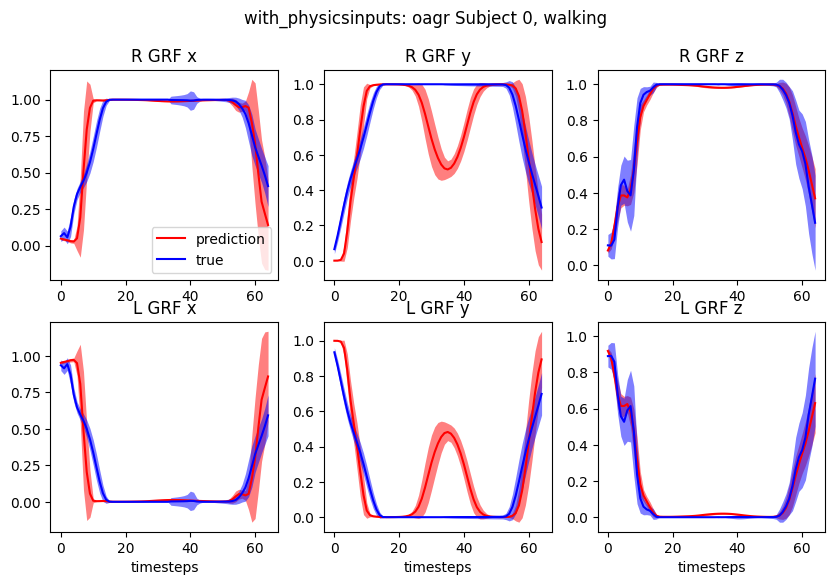

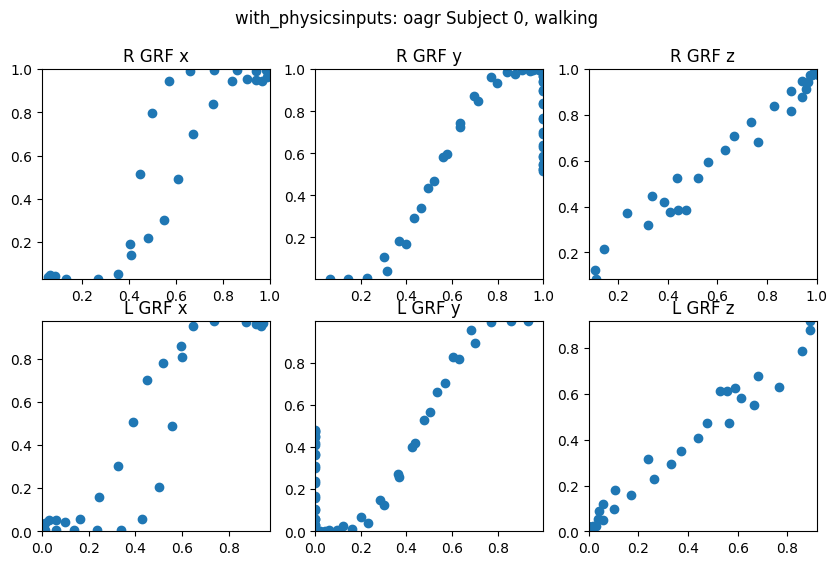

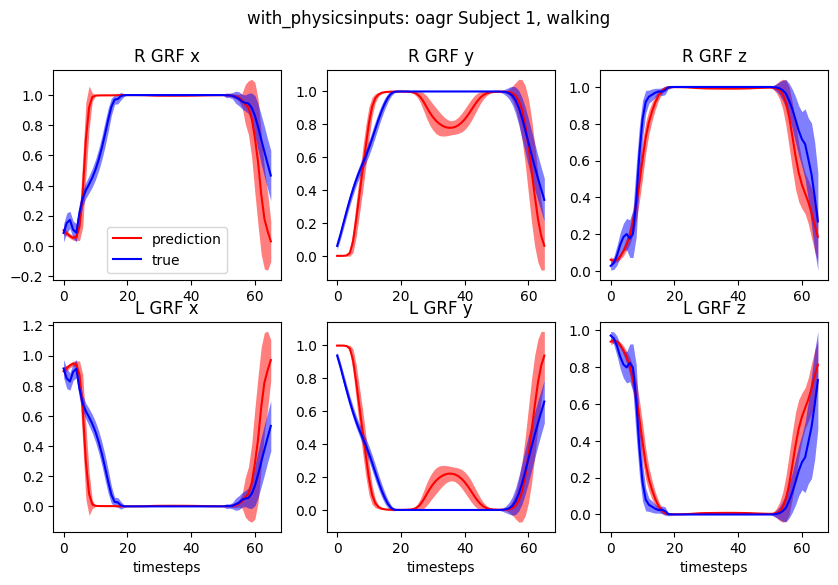

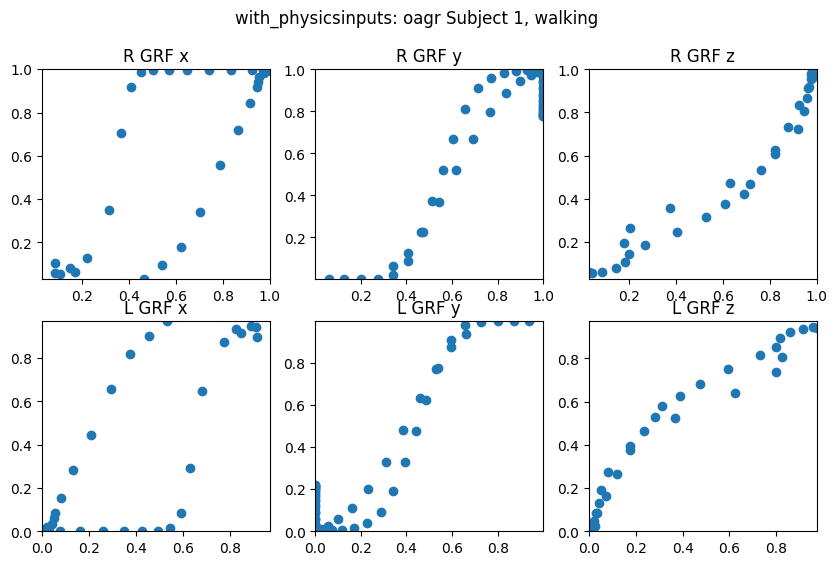

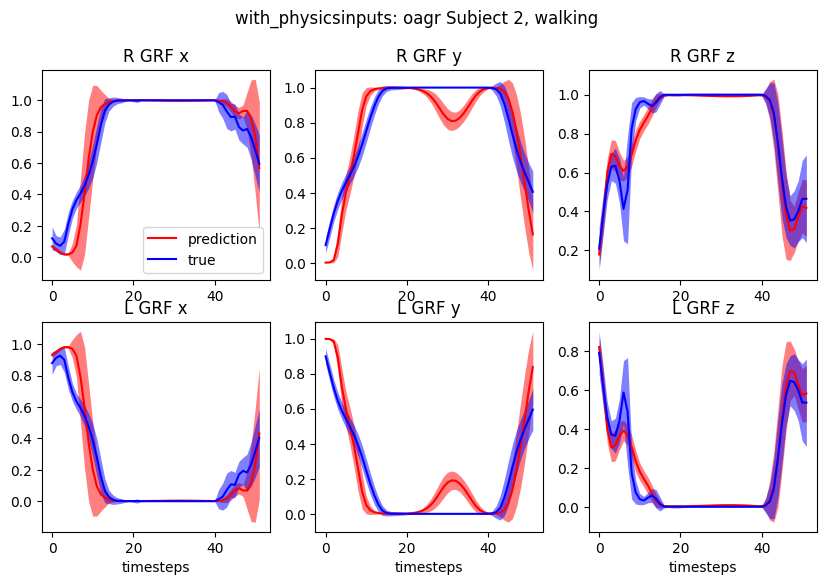

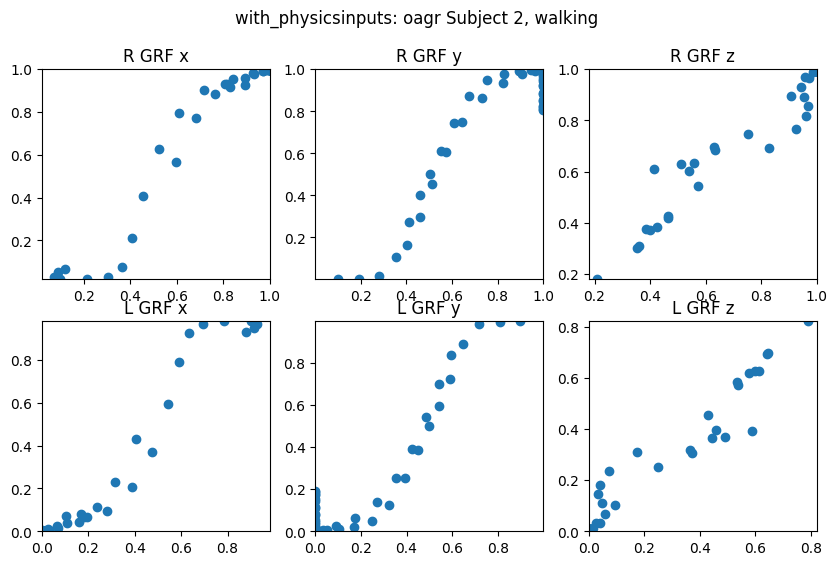

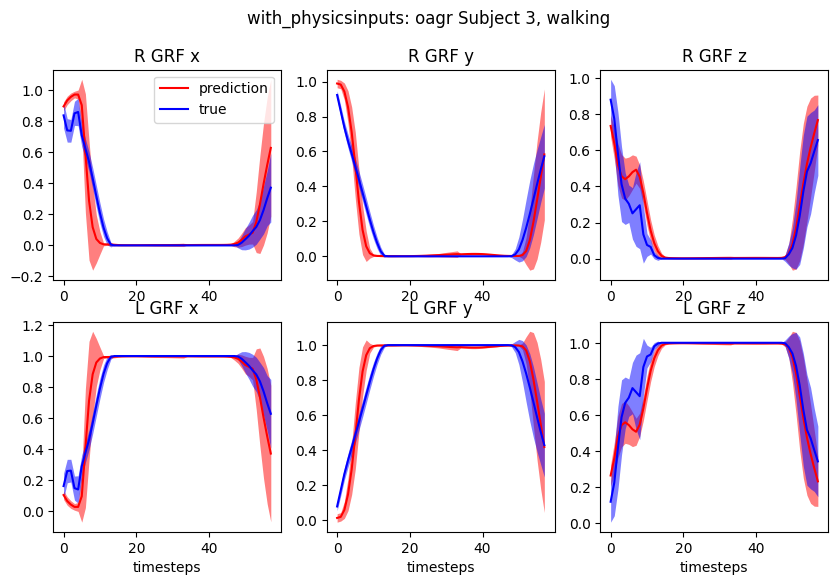

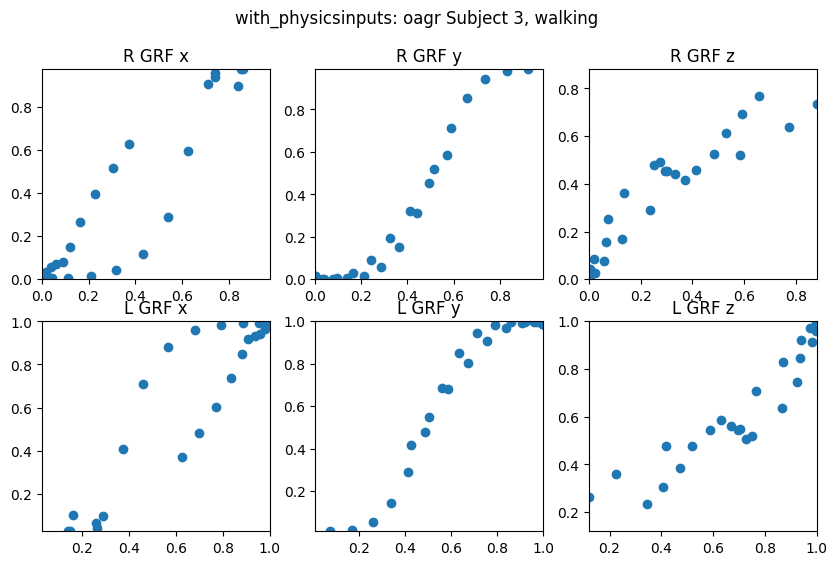

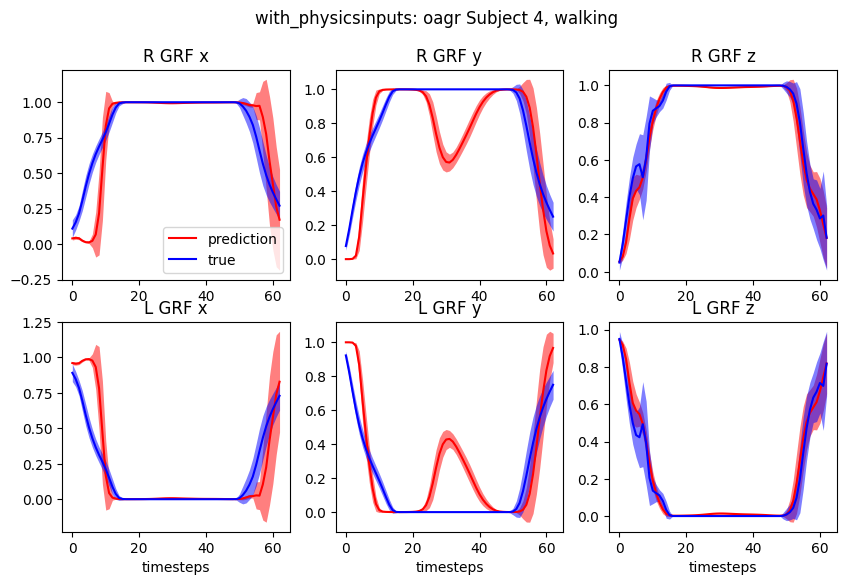

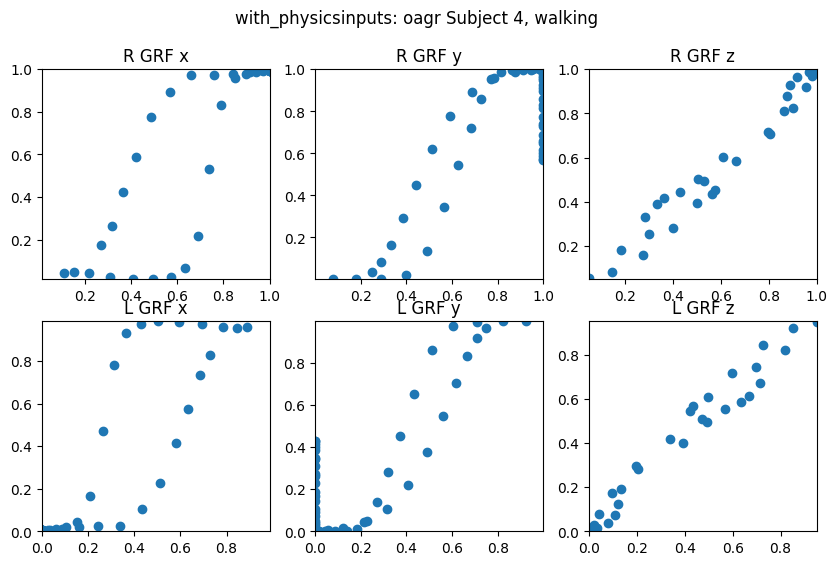

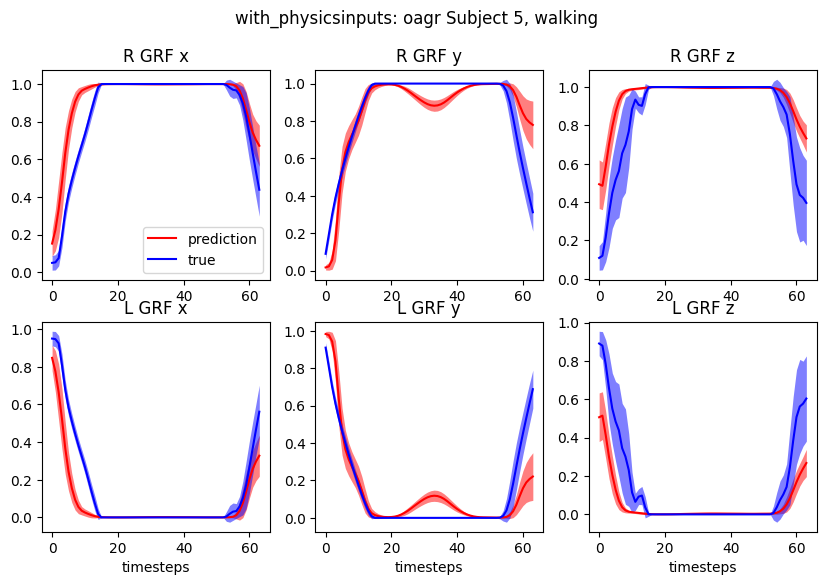

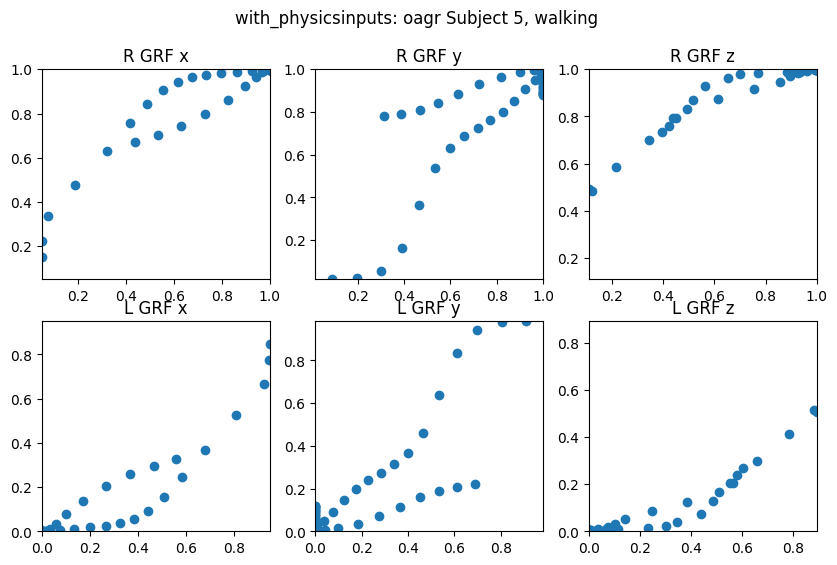

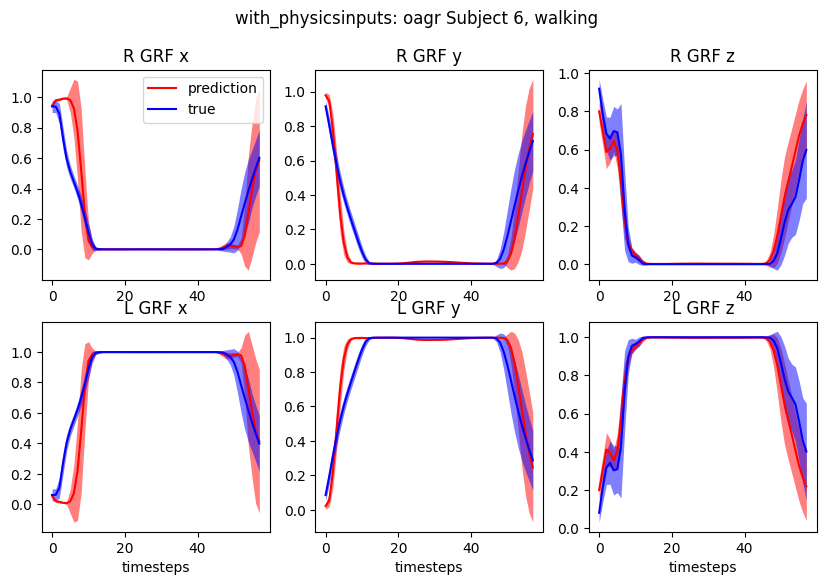

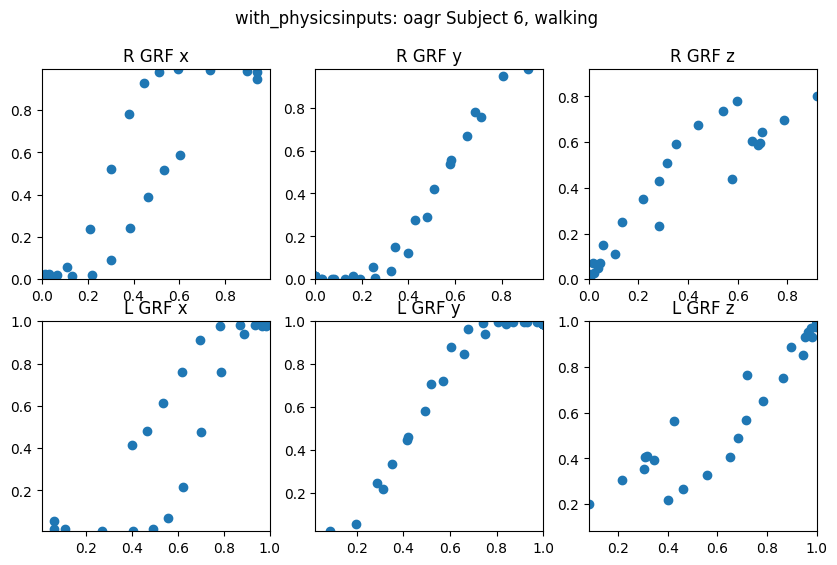

In [ ]:
# OAGR
num_test_subjs = 7
num_trials = 100
plot_savedir = os.path.join(BASE_DIR, 'reports','figures', EXP_TYPE + MODEL_NAME)

all_rmses = np.zeros((num_test_subjs, 6))
all_corrs = np.zeros((num_test_subjs, 6))

Y_pred_oagr = np.concatenate((Y_pred_dist_r[0:700,:,:], Y_pred_dist_l[0:700,:,:]), axis=-1)
Y_true_oagr = np.concatenate((Y_true_dist_r[0:700,:,:], Y_true_dist_l[0:700,:,:]), axis=-1)

for s in range(num_test_subjs):

    Y_pred_allfeats = Y_pred_oagr[num_trials*s:num_trials*(s+1), :, :]
    Y_true_allfeats = Y_true_oagr[num_trials*s:num_trials*(s+1), :, :]

    # Identify the minimum where masking/padding started for the given subject over all trials for given task.
    min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

    Y_pred = Y_pred_allfeats[:,0:min_timestep,:]
    Y_true = Y_true_allfeats[:,0:min_timestep,:]

    rmses, corrs = analyze_grf_dist(Y_true, Y_pred, EXP_TYPE, s, 'oagr', 'walking', plot_savedir, MASK_VALUE)
    all_rmses[s, :] = rmses
    all_corrs[s, :] = corrs

# Print error metrics to file
out_node_names = ['R GRF x', 'R GRF y', 'R GRF z',
                  'L GRF x', 'L GRF y', 'L GRF z']

pd.DataFrame(all_rmses).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'rmses_oagr_dist.xlsx'), header=out_node_names)
pd.DataFrame(all_corrs).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'corr_oagr_dist.xlsx'), header=out_node_names)

In [ ]:
# ACL
num_test_subjs = 7
num_trials = 3
acl_tasks = ['cutting','dj','lldj','rldj','unant_cut']
plot_savedir = os.path.join(BASE_DIR, 'reports','figures', EXP_TYPE + MODEL_NAME)

all_rmses = np.zeros((num_test_subjs, len(acl_tasks), 6))
all_corrs = np.zeros((num_test_subjs,len(acl_tasks), 6))

Y_pred_acl = np.concatenate((Y_pred_dist_r[700:,:,:], Y_pred_dist_l[700:,:,:]), axis=-1)
Y_true_acl = np.concatenate((Y_true_dist_r[700:,:,:], Y_true_dist_l[700:,:,:]), axis=-1)

for s in range(num_test_subjs):

    Y_pred_allsubjtasks = Y_pred_acl[num_trials*len(acl_tasks)*s:num_trials*len(acl_tasks)*(s+1), :, :]
    Y_true_allsubjtasks = Y_true_acl[num_trials*len(acl_tasks)*s:num_trials*len(acl_tasks)*(s+1), :, :]

    for task in range(len(acl_tasks)):

      Y_pred_allfeats = Y_pred_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]
      Y_true_allfeats = Y_true_allsubjtasks[num_trials*task:num_trials*(task+1),:,:]

      # Identify the minimum where masking/padding started for the given subject over all trials for given task.
      min_timestep = np.min(np.nonzero(Y_true_allfeats == MASK_VALUE)[1])

      Y_pred = Y_pred_allfeats[:,0:min_timestep,:]
      Y_true = Y_true_allfeats[:,0:min_timestep,:]

      rmses, corrs = analyze_grf_dist(Y_true, Y_pred, EXP_TYPE, s, 'acl', acl_tasks[task], plot_savedir, MASK_VALUE=999)
      all_rmses[s, task, :] = rmses
      all_corrs[s, task, :] = corrs

# Print error metrics to file
out_node_names = ['R GRF x', 'R GRF y', 'R GRF z',
                  'L GRF x', 'L GRF y', 'L GRF z']
for i, task in enumerate(acl_tasks):
  pd.DataFrame(all_rmses[:,i,:]).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'rmses_acl_' + task + '_dist.xlsx'), header=out_node_names)
  pd.DataFrame(all_corrs[:,i,:]).to_excel(os.path.join(BASE_DIR, 'reports', 'metrics', EXP_TYPE + MODEL_NAME, 'corr_acl_' + task + '_dist.xlsx'), header=out_node_names)

Output hidden; open in https://colab.research.google.com to view.

# Plot random trials

## Function for analysis

In [ ]:
def analyze_grf_rand(trial_num, Y_true_all, Y_pred_all, Y_train_means, Y_train_stds, data_type, USE_TRANSFORMED=False, MASK_VALUE=999):
  """
  Base function for calculating error metrics and plotting for x, y, and z for given GRF (right leg, left leg, or total).
  Data structures are of shape (num trials, timesteps, 3 (x, y, z)), where they all correspond to the same task for a given subject (already subset by min timestep).
  """
  out_node_names = ['R GRF x', 'R GRF y', 'R GRF z',
                    'L GRF x', 'L GRF y', 'L GRF z',
                    'Tot GRF x', 'Tot GRF y', 'Tot GRF z']

  acl_tasks = ['cutting','dj','lldj','rldj','unant_cut']

  # Append the datasets
  #Y_true = np.concatenate((Y_true_grf_r, Y_true_grf_l, Y_true_total_grf), axis=-1)
  #Y_pred = np.concatenate((Y_pred_grf_r, Y_pred_grf_l, Y_pred_total_grf), axis=-1)

  # Figure out dataset, etc. based on trial num
  if trial_num < 700:
    dataset = 'oagr'
    task = 'walking'
    subject_num = trial_num // 100
  else:
    dataset = 'acl'
    task_number = ((trial_num) % (3 * 5)) // 3
    task = acl_tasks[task_number]
    subject_num = ((trial_num) % (3 * 5)) // (3 * 5 // 7)

  # Subset data by min timestep for given trial num
  min_timestep = np.min(np.nonzero(Y_true_all == MASK_VALUE)[1])
  Y_pred_all = Y_pred_all[:,0:min_timestep,:]
  Y_true_all = Y_true_all[:,0:min_timestep,:]

  # Put means and stds structs in right order (shape: 1 x num features)
  Y_train_means = Y_train_means[:,[0,1,2, 8,9,10,11,12,13]]
  Y_train_stds = Y_train_stds[:,[0,1,2, 8,9,10,11,12,13]]

  # Store error metrics for all features
  rmses = np.zeros(9)
  corrs = np.zeros(9)

  # Create subplots for all the outputs for each subject.
  fig, axs = plt.subplots(3, 3, figsize=(15,15))
  fig.suptitle(f"{data_type}: {dataset} Subject {subject_num}, {task}")

  for f in range(9): # loop over all features

      # Subset Y_pred and Y_true based on given feature.
      Y_pred = Y_pred_all[trial_num,:,f]
      Y_true = Y_true_all[trial_num,:,f]

      # Reverse normalize based on which dataset training means and stds.
      if not USE_TRANSFORMED:
        # Get the indices of the zero values in Y_pred
        nonzero_indices = np.where(Y_pred != 0)
        # Reverse normalize the non-zero values
        Y_pred_nonzero = (Y_pred * Y_train_stds.T[f] + Y_train_means.T[f])
        # Assign the reverse normalized values only to the non-zero indices
        Y_pred[nonzero_indices] = Y_pred_nonzero[nonzero_indices]

        #Y_pred = (Y_pred*Y_train_stds.T[f] + Y_train_means.T[f])
        #Y_true = (Y_true*Y_train_stds.T[f] + Y_train_means.T[f]) # using unnormalized data

      # # ERROR METRICS # #
      # Calculate RMSE for each feature.
      rmses[f] = sqrt(mean_squared_error(Y_true.ravel(), Y_pred.ravel()))
      # Calculate corr for each feature.
      r = np.corrcoef(Y_true.ravel(), Y_pred.ravel())
      corr = r[0,1]
      if np.isnan(corr):
          corrs[f] = 0
      else:
          corrs[f] = corr

      # # PLOTTING # #
      # Add to subplots (vs. timesteps plot):
      if f < 3: row = 0
      elif f < 6: row = 1
      elif f < 9: row = 2

      axs[row, f%3].plot(Y_pred,'r',label='prediction')
      axs[row, f%3].plot(Y_true,'b',label='true')

      axs[row, f%3].set_title(out_node_names[f])
      if f == 0:
        axs[row, f%3].legend()
      if row == 2:
        axs[row, f%3].set_xlabel('timesteps')
      if f%3 == 0:
        axs[row, f%3].set_ylabel('BW')

  # Save figure for each subject.
  if not USE_TRANSFORMED:
    figname = dataset + '_' + task + '_subj' + str(s) + '.png'
  else:
    figname = dataset + '_' + task + '_subj' + str(s) + '_transformed.png'
  #plt.savefig(os.path.join(plot_savedir, figname))

  return rmses, corrs

## Process

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


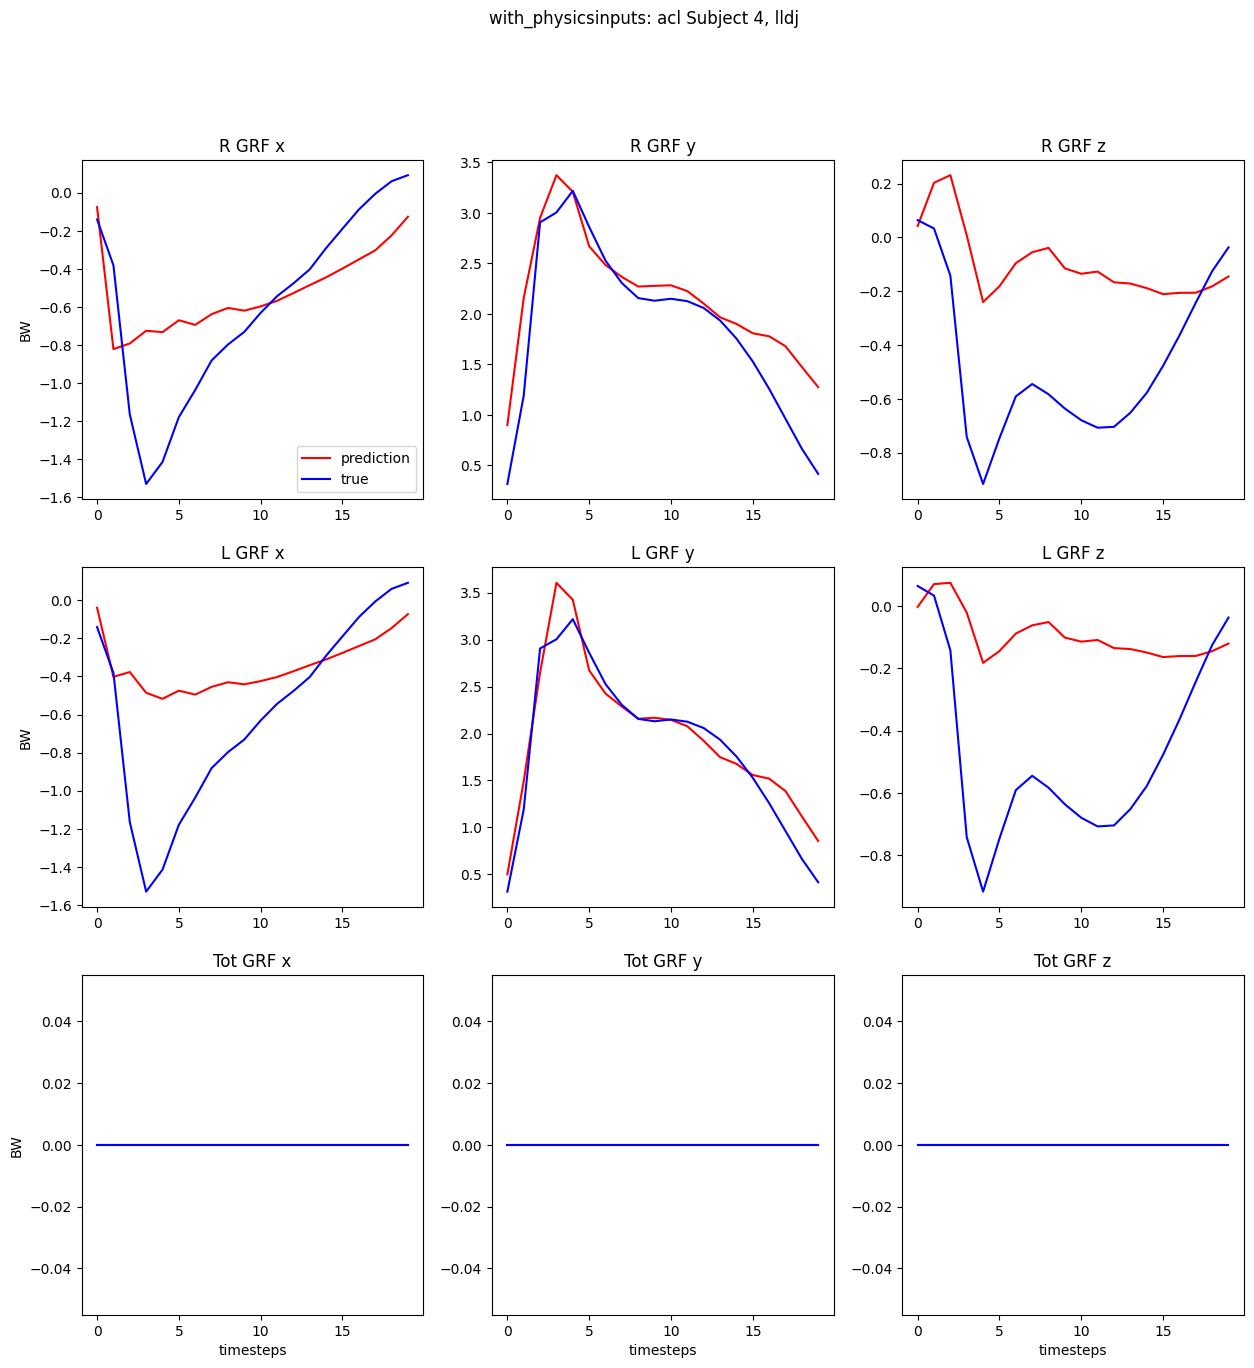

In [ ]:
trial_num = 743
rmses, corrs = analyze_grf_rand(trial_num, np.concatenate((Y_true_total_grf, Y_true_grf_r, Y_true_grf_l), axis=-1), np.concatenate((Y_pred_total_grf, Y_pred_grf_r, Y_pred_grf_l), axis=-1), Y_train_means, Y_train_stds, EXP_TYPE, USE_TRANSFORMED=False, MASK_VALUE=999)

In [ ]:
rmses

array([0.33903047, 0.43549034, 0.44610577, 0.44369044, 0.25974479,
       0.45451553, 0.        , 0.        , 0.        ])

# Obsolete
